In [1]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

np.random.seed(42)

In [2]:
# columns used frequently
"EXTN_TPRT", "DWP_TPRT", "EXTN_SRQT", 
"INNER_HMDT_1", "INNER_HMDT_2",
"INNER_TPRT_1", "INNER_TPRT_2"

('INNER_TPRT_1', 'INNER_TPRT_2')

# define useful functions

In [3]:
from util.log import describe_df

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

def preprocess(df):
    sc = MinMaxScaler()
    training_data = sc.fit_transform(df)

    seq_length = 36
    x, y = sliding_windows(training_data, seq_length)
    train_size = int(len(y) * 0.8)
    test_size = len(y) - train_size

    print(x.shape, y.shape)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
    trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

    testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

    print(trainX.shape, trainY.shape, testX.shape, testY.shape, sep="\n")
    print(trainX[0], trainY[0])
    print(trainX[1], trainY[1])
    print((trainX[1][-1]==trainY[0]).all())

    return train_size, sc, dataX, dataY, trainX, trainY, testX, testY 

In [6]:
from util.model import LSTM

def train(trainX, trainY, epoch=None):
    num_epochs = epoch if epoch else 2000
    learning_rate = 0.01

    input_size = trainX.shape[-1]
    hidden_size = 4
    num_layers = 1

    num_classes = trainY.shape[-1] # output_size

    lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        outputs = lstm(trainX)
        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, trainY)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    return lstm

In [8]:
from util.log import save_model, regression_results

def eval(lstm, X, Y, sc, train_size=None):
    lstm.eval()
    train_predict = lstm(X)
    print("X dataset shape & prediction shape:", X.shape, train_predict.shape)

    predict = train_predict.data.numpy()
    Y_plot = Y.data.numpy()

    predict = sc.inverse_transform(predict)
    Y_plot = sc.inverse_transform(Y_plot)

    regression_results(Y_plot, predict)

    plt.figure(figsize=(15, 5)) 
    if train_size:
        plt.axvline(x=train_size, c='r', linestyle='--')
    plt.plot(Y_plot)
    plt.plot(predict, linestyle='dotted')
    plt.suptitle('Time-Series Prediction')
    plt.show()

# 5min step

         EXTN_TPRT  INNER_TPRT_1  INNER_HMDT_1
count  5000.000000   5000.000000   5000.000000
mean      0.160968     17.322960     84.517208
std       3.692765      2.703058      6.544450
min      -8.600000     13.430000     56.700000
25%      -2.500000     15.350000     82.537500
50%       0.370000     16.400000     85.800000
75%       2.635000     18.570000     89.950000
max       9.200000     27.050000     94.450000


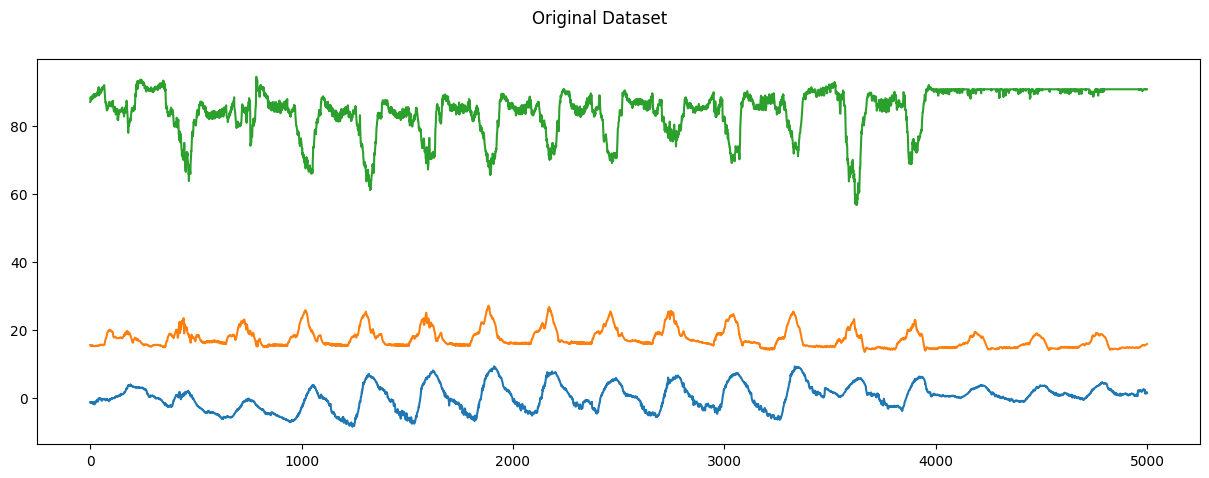

In [9]:
raw_df = pd.read_csv("merged.csv", usecols=["INNER_TPRT_1", "EXTN_TPRT", "INNER_HMDT_1"])
df = raw_df[:5000]
# df["MSRM_DT"] = (pd.to_datetime(df["MSRM_DT"]) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

describe_df(df)

In [10]:
train_size, sc, dataX, dataY, trainX, trainY, testX, testY = preprocess(df)

(4963, 36, 3) (4963, 3)
torch.Size([3970, 36, 3])
torch.Size([3970, 3])
torch.Size([993, 36, 3])
torch.Size([993, 3])
tensor([[0.4073, 0.1483, 0.8040],
        [0.4101, 0.1373, 0.8146],
        [0.3989, 0.1336, 0.8397],
        [0.3961, 0.1373, 0.8278],
        [0.4045, 0.1410, 0.8278],
        [0.3989, 0.1446, 0.8159],
        [0.4045, 0.1373, 0.8411],
        [0.4045, 0.1373, 0.8278],
        [0.3989, 0.1336, 0.8411],
        [0.3904, 0.1336, 0.8411],
        [0.3933, 0.1373, 0.8411],
        [0.4045, 0.1336, 0.8543],
        [0.4073, 0.1410, 0.8291],
        [0.3820, 0.1336, 0.8411],
        [0.3933, 0.1300, 0.8530],
        [0.4045, 0.1300, 0.8397],
        [0.3989, 0.1263, 0.8397],
        [0.3736, 0.1263, 0.8530],
        [0.3764, 0.1300, 0.8662],
        [0.3933, 0.1300, 0.8411],
        [0.3820, 0.1263, 0.8530],
        [0.3708, 0.1263, 0.8397],
        [0.4045, 0.1263, 0.8662],
        [0.4157, 0.1300, 0.8543],
        [0.4101, 0.1300, 0.8543],
        [0.3989, 0.1263, 0.8662]

In [11]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 0.46827


Epoch: 100, loss: 0.01528
Epoch: 200, loss: 0.00383
Epoch: 300, loss: 0.00243
Epoch: 400, loss: 0.00163
Epoch: 500, loss: 0.00089
Epoch: 600, loss: 0.00072
Epoch: 700, loss: 0.00064
Epoch: 800, loss: 0.00059
Epoch: 900, loss: 0.00055
Epoch: 1000, loss: 0.00052
Epoch: 1100, loss: 0.00049
Epoch: 1200, loss: 0.00047
Epoch: 1300, loss: 0.00046
Epoch: 1400, loss: 0.00044
Epoch: 1500, loss: 0.00043
Epoch: 1600, loss: 0.00043
Epoch: 1700, loss: 0.00042
Epoch: 1800, loss: 0.00041
Epoch: 1900, loss: 0.00041


In [12]:
save_model(lstm)

parameter size: 0.000607MB
model dict size: 744


X dataset shape & prediction shape: torch.Size([4963, 36, 3]) torch.Size([4963, 3])
explained_variance:  0.9902
median_absolute_error:  0.2263
r2:  0.9902
MAE:  0.3235
MSE:  0.2918
RMSE:  0.5402


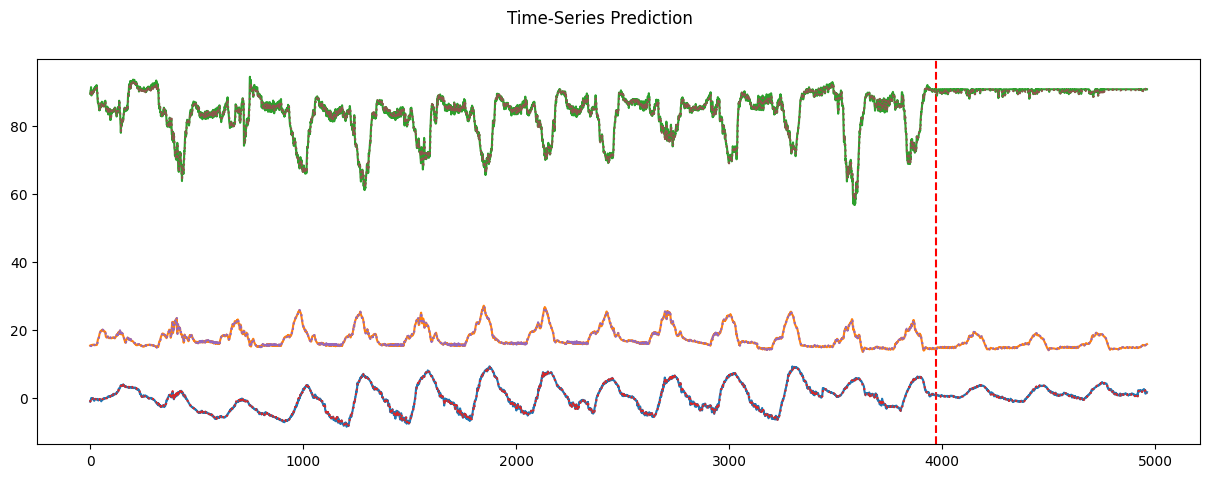

In [13]:
eval(lstm, dataX, dataY, sc, train_size)

X dataset shape & prediction shape: torch.Size([993, 36, 3]) torch.Size([993, 3])
explained_variance:  0.8077
median_absolute_error:  0.1492
r2:  0.7209
MAE:  0.1772
MSE:  0.0687
RMSE:  0.2621


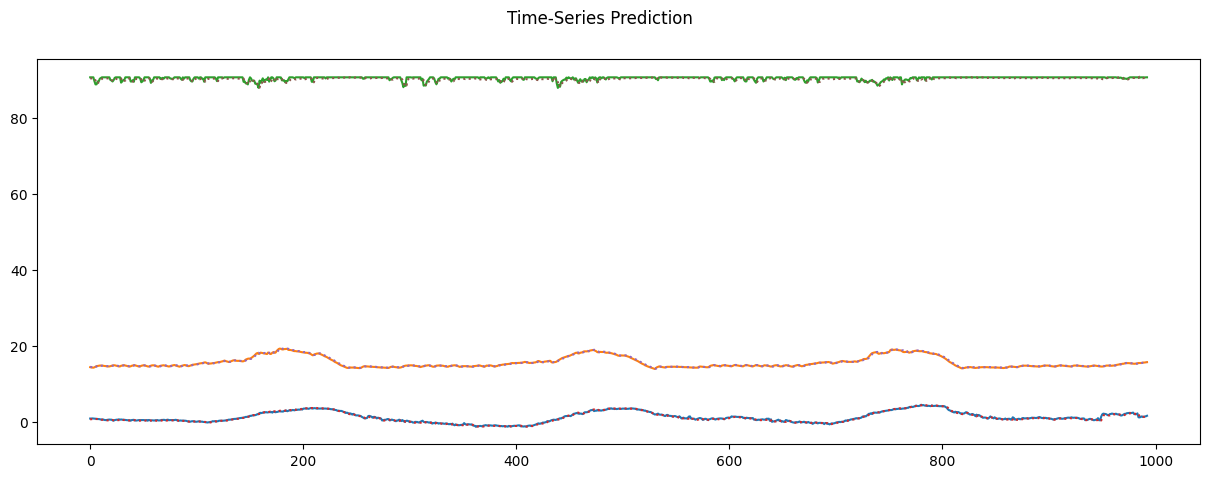

In [14]:
eval(lstm, testX, testY, sc)

# 1hour step

         EXTN_TPRT  INNER_TPRT_1  INNER_HMDT_1
count  2016.000000   2016.000000   2016.000000
mean      9.876235     18.834410     81.606900
std       8.588033      4.679379     11.550811
min     -11.730000     12.030000     40.130000
25%       2.900000     14.870000     73.870000
50%       9.870000     17.600000     86.000000
75%      16.870000     21.830000     90.100000
max      31.500000     34.500000     99.100000


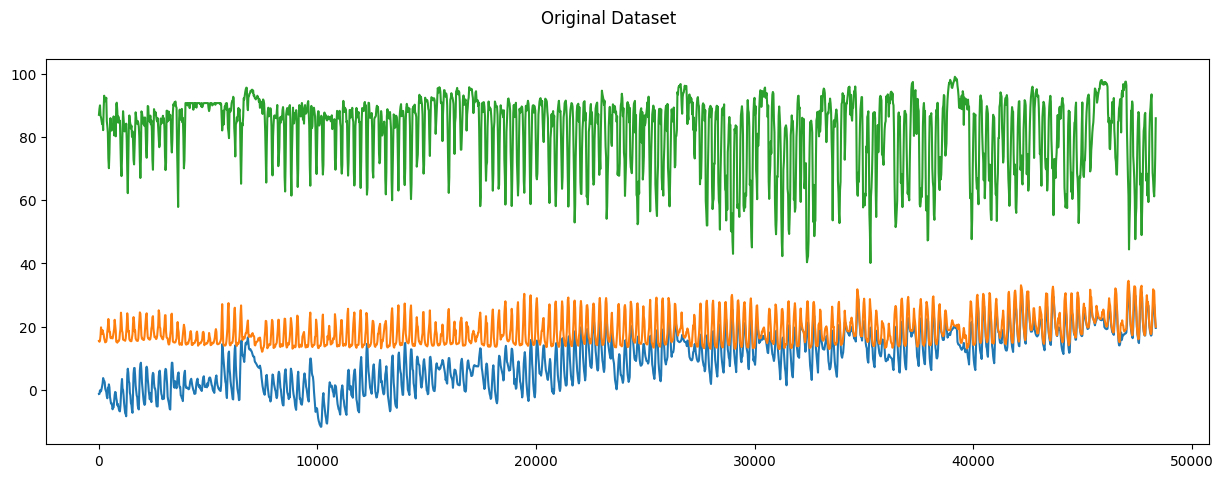

In [15]:
df1h = raw_df[::24]
describe_df(df1h)

In [16]:
train_size, sc, dataX, dataY, trainX, trainY, testX, testY = preprocess(df1h)

(1979, 36, 3) (1979, 3)
torch.Size([1583, 36, 3])
torch.Size([1583, 3])
torch.Size([396, 36, 3])
torch.Size([396, 3])
tensor([[0.2401, 0.1522, 0.7957],
        [0.2413, 0.1411, 0.8279],
        [0.2667, 0.1567, 0.8465],
        [0.2598, 0.2234, 0.7914],
        [0.2598, 0.3436, 0.7821],
        [0.2760, 0.2568, 0.7634],
        [0.2956, 0.2501, 0.7465],
        [0.3176, 0.3035, 0.7634],
        [0.3569, 0.2679, 0.7134],
        [0.3419, 0.2457, 0.8245],
        [0.3373, 0.1900, 0.8983],
        [0.3257, 0.1633, 0.8720],
        [0.2794, 0.1322, 0.8686],
        [0.2656, 0.1544, 0.8711],
        [0.2551, 0.1433, 0.8872],
        [0.2228, 0.1945, 0.7617],
        [0.2089, 0.2835, 0.7355],
        [0.2864, 0.3502, 0.6982],
        [0.2737, 0.4615, 0.5591],
        [0.3107, 0.3769, 0.5091],
        [0.2887, 0.2790, 0.5888],
        [0.2204, 0.2768, 0.7219],
        [0.1927, 0.1967, 0.7779],
        [0.1707, 0.1900, 0.7389],
        [0.1742, 0.2078, 0.7109],
        [0.1580, 0.1945, 0.7431]

In [17]:
lstm = train(trainX, trainY)

Epoch: 0, loss: 0.35287


Epoch: 100, loss: 0.02241
Epoch: 200, loss: 0.00985
Epoch: 300, loss: 0.00677
Epoch: 400, loss: 0.00578
Epoch: 500, loss: 0.00525
Epoch: 600, loss: 0.00502
Epoch: 700, loss: 0.00485
Epoch: 800, loss: 0.00470
Epoch: 900, loss: 0.00456
Epoch: 1000, loss: 0.00442
Epoch: 1100, loss: 0.00432
Epoch: 1200, loss: 0.00423
Epoch: 1300, loss: 0.00417
Epoch: 1400, loss: 0.00424
Epoch: 1500, loss: 0.00408
Epoch: 1600, loss: 0.00425
Epoch: 1700, loss: 0.00401
Epoch: 1800, loss: 0.00397
Epoch: 1900, loss: 0.00394


In [18]:
save_model(lstm)

parameter size: 0.000607MB
model dict size: 744


X dataset shape & prediction shape: torch.Size([1979, 36, 3]) torch.Size([1979, 3])
explained_variance:  0.8922
median_absolute_error:  1.4981
r2:  0.8911
MAE:  1.9905
MSE:  9.6621
RMSE:  3.1084


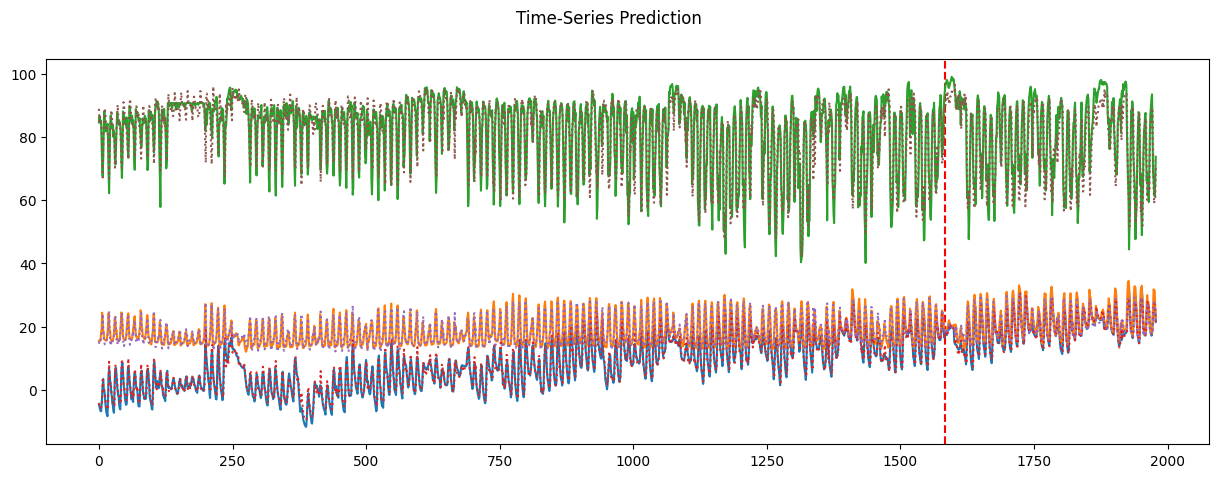

In [19]:
eval(lstm, dataX, dataY, sc, train_size)

X dataset shape & prediction shape: torch.Size([396, 36, 3]) torch.Size([396, 3])
explained_variance:  0.8701
median_absolute_error:  1.9695
r2:  0.8475
MAE:  2.3865
MSE:  12.9945
RMSE:  3.6048


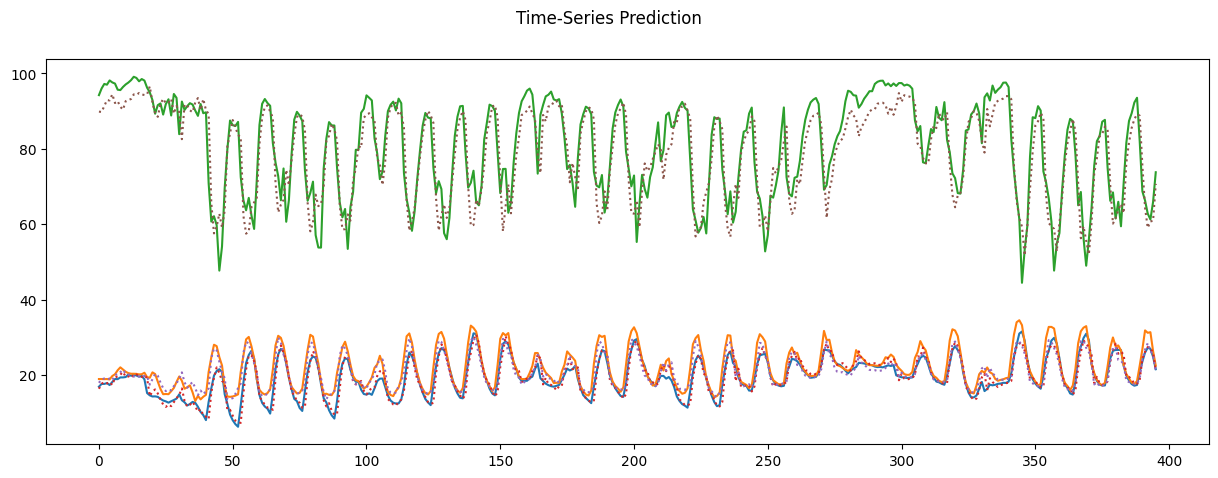

In [20]:
eval(lstm, testX, testY, sc)